In [66]:
! which python3
! python3 -V

/Users/nick/Dev/magisterka/venv/bin/python3
Python 3.9.6


In [67]:
import typing as t
import jax.numpy as jnp
import metadata
import haiku as hk
import utils
import jax
import optax
import data
import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_debug_nans", True)

### Statics

In [68]:
BLOCK_SIZE = int(24*60/5) # 2 days
BATCH_SIZE = 8
SPLIT = 0.85
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-3
SEED = 2137
NUM_TRAINING_STEPS = 300
EVAL_INTERVAL = 10
EMBEDDING_SIZE = 1

### Load data

In [69]:
sdl = data.SimpleDataLoader("../data/samples_5m_subset_v1.pkl", BLOCK_SIZE, BATCH_SIZE, EMBEDDING_SIZE, SPLIT)
train_di = sdl.get_data_iter("train")
test_di = sdl.get_data_iter("test", "uci", "ftj")

In [70]:
expl_batch = next(train_di)
expl_batch["target"].shape

(288, 8)

### Model

In [71]:
class TrainingState(t.NamedTuple):
    params: hk.Params
    opt_state: optax.OptState

class LoopValues(t.NamedTuple):
    logits: jnp.ndarray
    state: t.Any

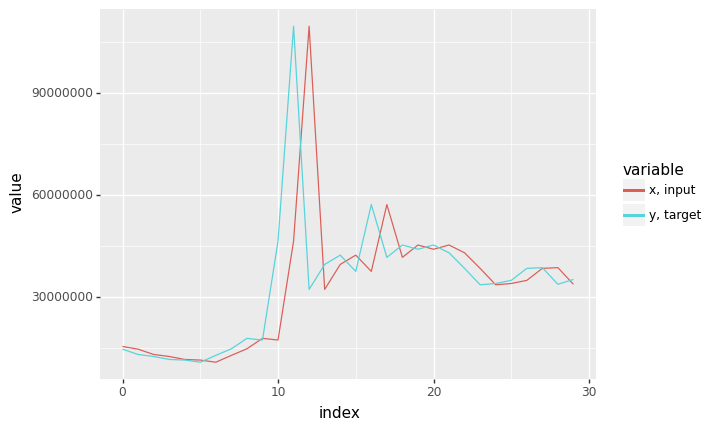

In [72]:
_off = 30
plot = utils.plot_samples(
    truth=expl_batch['target'][:_off, 0],
    prediction=expl_batch['input'][:_off, 0],
    truth_label='y, target',
    prediction_label='x, input')
plot.draw()

Glossary of shapes:
B: Batch size.
T: Sequence length aka Time dimension of a time series.
F: Number of features aka model embedding size.
H: Hidden size of a NN.
V: Block size.

In [73]:
@jax.jit
def embed(arr: jnp.array) -> jnp.array:
    arr = jnp.log(arr + 1)
    return arr[:, :, None]  # (T, B, F)

def make_network() -> hk.Module:
    """Defines the network architecture."""
    model = hk.DeepRNN([
        hk.GRU(HIDDEN_SIZE),
        hk.LayerNorm(axis = 1, param_axis = -1, create_scale=True, create_offset=True),
        jax.nn.relu,
        hk.Linear(EMBEDDING_SIZE)
    ])
    return model

def make_optimizer() -> optax.GradientTransformation:
    """Defines the optimizer."""
    return optax.adam(LEARNING_RATE)

def sequence_loss(batch: data.Batch) -> jnp.ndarray:
    """Unrolls the network over a sequence of inputs & targets, gets loss."""
    core = make_network()

    sequence_length, batch_size = batch['input'].shape  # (T, B)

    initial_state = core.initial_state(batch_size)

    _input = embed(batch['input'])  # (T, B, F)
    logits, _ = hk.dynamic_unroll(core, _input, initial_state)  # (T, B, H)

    loss = jnp.mean(jnp.abs(embed(batch['target']) - logits))  # MAE
    return loss

@jax.jit
def update(state: TrainingState, batch: data.Batch) -> TrainingState:
    """Does a step of SGD given inputs & targets."""
    _, optimizer = make_optimizer()
    _, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
    gradients = jax.grad(loss_fn)(state.params, batch)
    updates, new_opt_state = optimizer(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)
    return TrainingState(params=new_params, opt_state=new_opt_state)

def generate(context: jnp.ndarray, seq_len: int) -> jnp.array:
    """Draws samples from the model, given an initial context."""
    core = make_network()

    sequence_length, batch_size = context.shape  # (T, B)

    initial_state = core.initial_state(batch_size)
    _input = embed(context)  # (T, B, F)

    context_outs, _state = hk.dynamic_unroll(core, _input, initial_state)  # (T, B, V)

    def body_fn(t: int, v: LoopValues) -> LoopValues:
        logit = v.logits[t]
        new_logit, new_state = core(logit, v.state)  # (1, V)
        new_logits = v.logits.at[t+1].set(new_logit)
        return LoopValues(logits=new_logits, state=new_state)

    output_seq = jnp.zeros((seq_len - sequence_length, batch_size, EMBEDDING_SIZE))
    output_seq = output_seq.at[0].set(context_outs[0])
    initial_values = LoopValues(logits=output_seq, state=_state)
    lv: LoopValues = hk.fori_loop(0, seq_len - sequence_length, body_fn, initial_values)
    return jnp.concatenate([context_outs, lv.logits])

In [74]:
rng = hk.PRNGSequence(SEED)

init_params_fn, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
loss_fn = jax.jit(loss_fn)
initial_params = init_params_fn(next(rng), expl_batch)
opt_init, _ = make_optimizer()
initial_opt_state = opt_init(initial_params)

# de facto initial state
state = TrainingState(params=initial_params, opt_state=initial_opt_state)

In [75]:
def train(state):
    train_loss_all = jnp.array([])
    eval_loss_all = jnp.array([])

    for step in range(NUM_TRAINING_STEPS):
        train_batch = next(train_di)
        state = update(state, train_batch)

        if step % EVAL_INTERVAL == 0:
            eval_batch = next(test_di)
            train_loss = loss_fn(state.params, train_batch)
            eval_loss = loss_fn(state.params, eval_batch)
            train_loss_all = jnp.append(train_loss_all, train_loss)
            eval_loss_all = jnp.append(eval_loss_all, eval_loss)
            print({
                'step': step,
                'train_loss': float(train_loss),
                'eval_loss': float(eval_loss)
            })

    return state, train_loss_all, eval_loss_all

final_state, train_loss_arr, eval_loss_arr = train(state)

{'step': 0, 'train_loss': 10.511286735534668, 'eval_loss': 14.023872375488281}
{'step': 10, 'train_loss': 8.68790054321289, 'eval_loss': 12.541435241699219}
{'step': 20, 'train_loss': 7.007184982299805, 'eval_loss': 11.037847518920898}
{'step': 30, 'train_loss': 5.972975730895996, 'eval_loss': 9.515152931213379}
{'step': 40, 'train_loss': 5.161818504333496, 'eval_loss': 8.113659858703613}
{'step': 50, 'train_loss': 4.656312465667725, 'eval_loss': 6.966521263122559}
{'step': 60, 'train_loss': 4.2068095207214355, 'eval_loss': 6.010890483856201}
{'step': 70, 'train_loss': 3.6631250381469727, 'eval_loss': 5.166097164154053}
{'step': 80, 'train_loss': 2.9728291034698486, 'eval_loss': 4.105137825012207}
{'step': 90, 'train_loss': 2.2306935787200928, 'eval_loss': 2.8849637508392334}
{'step': 100, 'train_loss': 1.4799004793167114, 'eval_loss': 1.3972032070159912}
{'step': 110, 'train_loss': 0.9333261847496033, 'eval_loss': 0.3728128671646118}
{'step': 120, 'train_loss': 0.518991231918335, 'eva

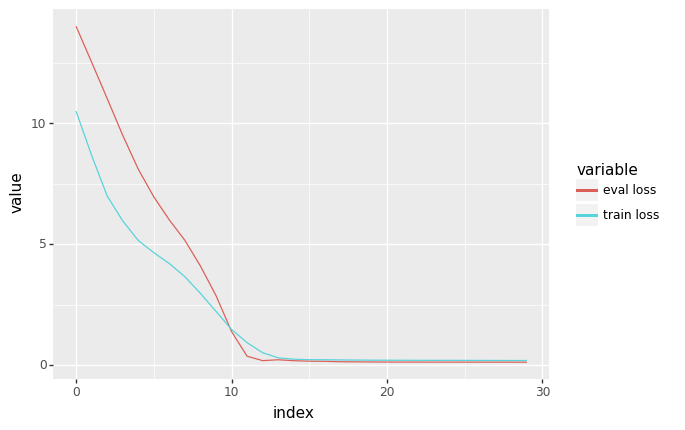

In [76]:
plot = utils.plot_samples(
    truth=train_loss_arr,
    prediction=eval_loss_arr,
    truth_label='train loss',
    prediction_label='eval loss')
plot.draw()

### Generating data from the model

In [77]:
init_gen_fn, generate_fn = hk.without_apply_rng(hk.transform(generate))
predict = jax.jit(generate_fn, static_argnums=2)

In [78]:
val_batch = next(test_di)
context = val_batch["input"][:, :1]
predicted = generate_fn(final_state.params, context, BLOCK_SIZE*2 )

In [79]:
predicted.shape, val_batch["target"].shape

((576, 1, 1), (288, 8))

In [80]:
print(f" MAE: {jnp.mean(jnp.abs(embed(val_batch['target'][:, :1]) - predicted[:BLOCK_SIZE])):.4f}")
print(f" MSE: {jnp.mean(jnp.square(embed(val_batch['target'][:, :1]) - predicted[:BLOCK_SIZE])):.4f}")

 MAE: 0.1280
 MSE: 0.0547


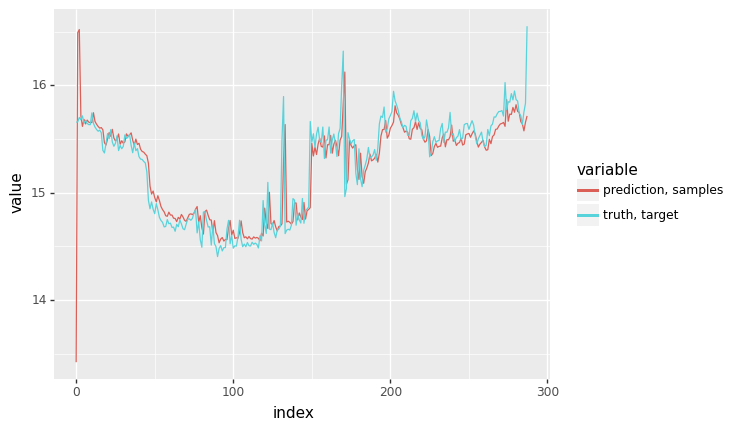

In [81]:
plot = utils.plot_samples(
    embed(val_batch['target'][:, :1]),
    predicted[:BLOCK_SIZE],
    truth_label='truth, target',
    prediction_label='prediction, samples')
plot.draw()

### Neighbour error correlation

the goal is:
* run the model over test data for each node;
* collect error (truth - model output) data;
* compose a correlation matrix;
* draw a heatmap of correlations;

notes:
* errors should be calculated using denormalized data;

In [82]:
model_errors = {}
for src, dst in metadata.CONNECTIONS:
    _test_di = sdl.get_data_iter("test", src, dst)
    model_errors[(src, dst)] = jnp.array([])
    for _ in range(3):
        test_batch = next(_test_di)

        context = test_batch["input"]
        predicted = generate_fn(final_state.params, context, BLOCK_SIZE+1)
        denormalized_target = embed(test_batch["target"])
        denormalized_predictions = predicted[:-1]
        error = jnp.ravel(denormalized_target - denormalized_predictions)
        model_errors[(src, dst)] = jnp.append(model_errors[(src, dst)], error)

In [83]:
corr_matrix = jnp.zeros((metadata.NUM_EDGES**2, 1))
_map = metadata.NODE_IDS_TO_LABELS_MAPPING
x = 0
for a in metadata.CONNECTIONS:
    for b in metadata.CONNECTIONS:
        if a == b:
            _corr = .0
        else:
            _corr = jnp.corrcoef(model_errors[a], model_errors[b])[0, 1]
        corr_matrix = corr_matrix.at[x].set(_corr)
        x += 1

corr_matrix = corr_matrix.reshape((metadata.NUM_EDGES, metadata.NUM_EDGES))

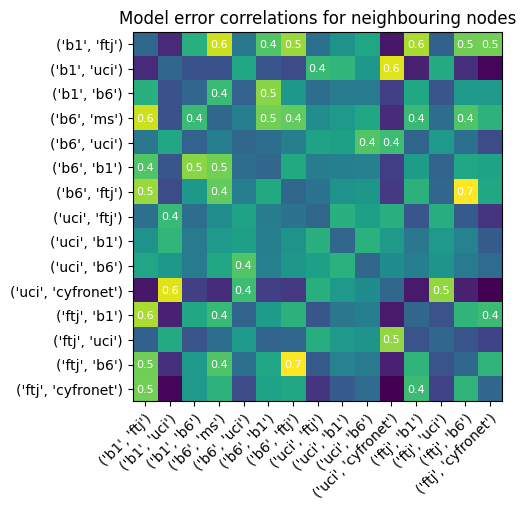

In [88]:
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix)

ax.set_xticks(jnp.arange(len(metadata.CONNECTIONS)), labels=metadata.CONNECTIONS)
ax.set_yticks(jnp.arange(len(metadata.CONNECTIONS)), labels=metadata.CONNECTIONS)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# create text annotations
for i in range(metadata.NUM_EDGES):
    for j in range(metadata.NUM_EDGES):
        # we're not interested in correlations below 0.35
        lb = "" if -.35 < corr_matrix[i, j] < .35 else f"{corr_matrix[i, j]:.1f}"
        text = ax.text(j, i, lb, ha="center", va="center", color="w", size=8)

ax.set_title("Model error correlations for neighbouring nodes")
plt.show()

### Autoregressive predictions - it generally sucks

In [85]:
val_batch = next(test_di)
context = val_batch["input"][:BLOCK_SIZE // 2, :1]
predicted = generate_fn(final_state.params, context, BLOCK_SIZE)  # (T, B, F)

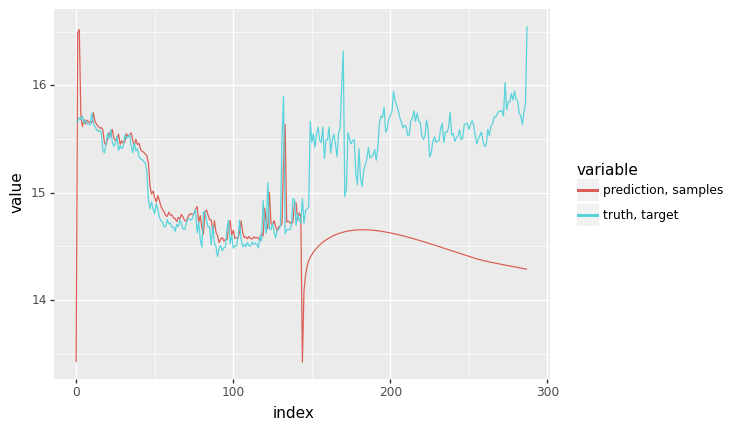

In [86]:
plot = utils.plot_samples(
    embed(val_batch["target"][:, :1]),
    predicted,
    truth_label='truth, target',
    prediction_label='prediction, samples')
plot.draw()